#### Y and KPY organoid co-culture scRNA-Seq analysis

In [1]:
import os
import glob
import scanpy as sc
import scanpy.external as sce
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from seaborn import despine
from seaborn import axes_style
import magic # imputation tool; van Dijk et al 2018 # 
from matplotlib.pyplot import suptitle
import matplotlib.colors
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch # for clustermap legends
import time

sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1


#### Pre processing AT2-mesenchyme organoid co-culture time course data

The following h5 files were used for analysis:['/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/organoids/AD01_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/organoids/AD02_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/organoids/AD03_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/organoids/AD04_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/organoids/AD05_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/organoids/AD06_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h5_files/organoids/AD07_filtered_feature_bc_matrix.h5', '/n/data2/bch/hemonc/ckim/AARON/20190715_KPY_timecourse/data_analysis/h

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Vari

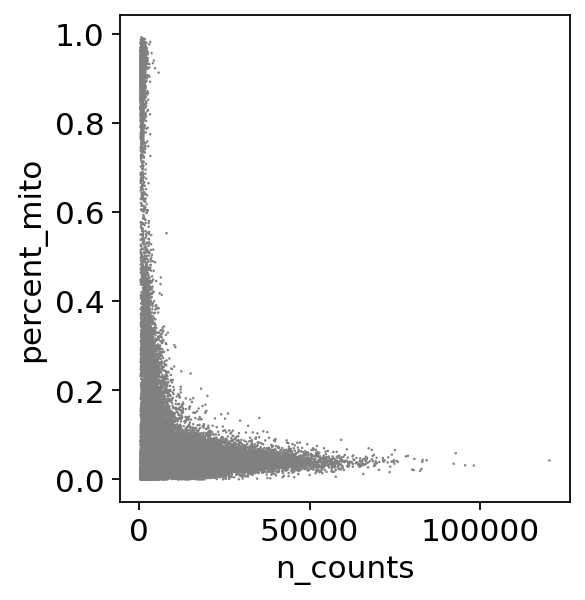

In [12]:
# Define the path to the directory containing h5 files
h5_path = 'path/to/h5/files'

# Use glob to find all files in the h5_path directory with a .h5 extension
filenames_input = glob.glob('%s/*.h5'%h5_path)

# Sort the filenames in alphabetical order for consistency
filenames = sorted(filenames_input)

# Print the sorted list of h5 filenames
print('The following h5 files were used for analysis:%s'%filenames)

# Initialize an empty list to store categories
categories = []

# Iterate over each file in the h5_path directory
for files in os.listdir(h5_path):
    # Check if the file ends with the .h5 extension
    if files.endswith(".h5"):
        # Split the file name by commas, then by underscores, to extract categories
        category = files.split(',')[0].split('_')
        # Append the extracted category to the categories list
        categories.append(category) # turns files names into list of lists

# Extract the first element of each category list to get the batch category names
extracted_batch_categories = [categories[i][0] for i in range(len(categories))]

# Sort the extracted batch categories in alphabetical order
extracted_batch_categories.sort()

# Read the h5 files using sc.read_10x_h5 and store the results in a list
adatas = [sc.read_10x_h5(filename) for filename in filenames]

# Concatenate the AnnData objects from the list, using the extracted batch categories to differentiate the batches
adata = adatas[0].concatenate(adatas[1:], batch_categories=extracted_batch_categories)

# Ensure that the gene names in the AnnData object are unique
adata.var_names_make_unique()

# Identify mitochondrial genes (those starting with 'mt-')
mito_genes = adata.var_names.str.startswith('mt-')

# Calculate the percentage of mitochondrial genes for each cell
# The `.A1` is used to convert the sparse matrix to a dense array after summing
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

# Add the total counts per cell as an observation annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

# Set figure parameters for plotting
sc.settings.set_figure_params(dpi=80)

# Plot a scatter plot of percent_mito vs. n_counts, turning off the grid in the plot
with axes_style({'axes.grid': False}):
    sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5)

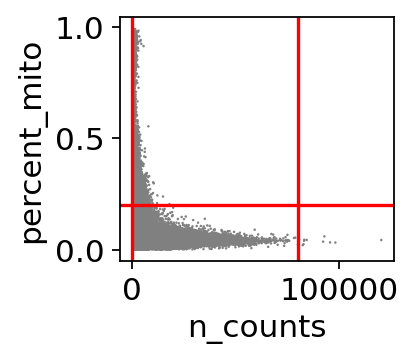

In [13]:
# Plot and include filter lines in red
sc.settings.set_figure_params(dpi=80)
rcParams['figure.figsize']=3,2
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5, show = False)
 plt.axvline(80000, color='red')
 plt.axvline(200, color='red')
 plt.axhline(0.2, color='red')

In [14]:
# Filter adata
adata = adata[adata.obs['percent_mito'] < 0.2, :]
adata = adata[adata.obs['n_counts'] < 80000, :]
adata = adata[adata.obs['n_counts'] > 200, :]
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=1)

Trying to set attribute `.var` of view, copying.


In [15]:
# Normalize the data in the AnnData object (adata)
# The normalization sets total counts in each cell sum to 10,000.
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data in the AnnData object
sc.pp.log1p(adata)

# Set the .raw attribute of the AnnData object
adata.raw = adata

In [34]:
# Extract the 'batch' column from the observations (obs) attribute of the AnnData object (adata). 
# Creates a DataFrame 'scores' with index as the cell identifiers and one column 'batch'
scores = adata.obs[['batch']]

# Initialize a pandas Series named 'annotation' with the value 'Undetermined' for each index in 'scores'
# The index of 'annotation' corresponds to the cell identifiers
annotation = pd.Series('Undetermined', index=scores.index)

# Annotate time points based on the batch information. Each specified batch is assigned a corresponding time point
annotation[(scores.batch == 'AD01')|(scores.batch == 'AD02')|(scores.batch == 'AD03')] = '0 days'
annotation[(scores.batch == 'AD04')|(scores.batch == 'AD05')|(scores.batch == 'AD06')|(scores.batch == 'AD07')] = '04 days'  
annotation[(scores.batch == 'AD08')|(scores.batch == 'AD09')|(scores.batch == 'AD10')|(scores.batch == 'AD11')] = '07 days'  
annotation[(scores.batch == 'AD12')|(scores.batch == 'AD13')|(scores.batch == 'AD14')|(scores.batch == 'AD15')] = '10 days'  
annotation[(scores.batch == 'AD16')|(scores.batch == 'AD17')|(scores.batch == 'AD18')|(scores.batch == 'AD19')] = '14 days'  

# Add the annotated time points to the AnnData object's observations as a new column 'time point'
adata.obs['time point'] = annotation

# Initialize another annotation for cell type as 'AT2' for all cells
annotation = pd.Series('AT2', index=scores.index)

# Annotate specific batches as 'Stromal/mesenchyme' 
# Cells in specified batches are labeled as 'Stromal', others remain as 'AT2'
annotation[(scores.batch == 'AD03')|(scores.batch == 'AD05')|(scores.batch == 'AD07')|(scores.batch == 'AD09')|(scores.batch == 'AD11')|(scores.batch == 'AD13')|(scores.batch == 'AD15')|(scores.batch == 'AD17')|(scores.batch == 'AD19')] = 'Stromal'

# Add the cell type annotations to the AnnData object's observations as a new column 'cell type'
adata.obs['cell type'] = annotation

#### PCA and UMAP

In [20]:
# Perform Principal Component Analysis (PCA) dimensionality reduction on the AnnData object (adata)
# This solver 'arpack' is chosen for its ability to compute the largest few singular values more efficiently,
# and its reproducibility across runs.
sc.tl.pca(adata, svd_solver='arpack')

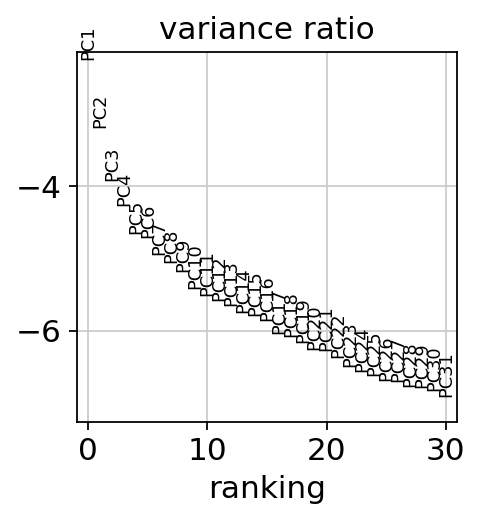

In [24]:
# Plot the variance ratio (proportion of total variance) for each principal component.
rcParams['figure.figsize'] = 3, 3
sc.pl.pca_variance_ratio(adata, log=True)

Performing MAGIC
  Running MAGIC with `solver='exact'` on 21001-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


  Running MAGIC with `solver='exact'` on 21001-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


  Running MAGIC with `solver='exact'` on 21001-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):
... storing 'time point' as categorical
... storing 'cell type' as categorical


Plotting data


... storing 'time point' as categorical
... storing 'cell type' as categorical
... storing 'time point' as categorical
... storing 'cell type' as categorical
... storing 'time point' as categorical
... storing 'cell type' as categorical


Total run time (min): 26.188187742233275


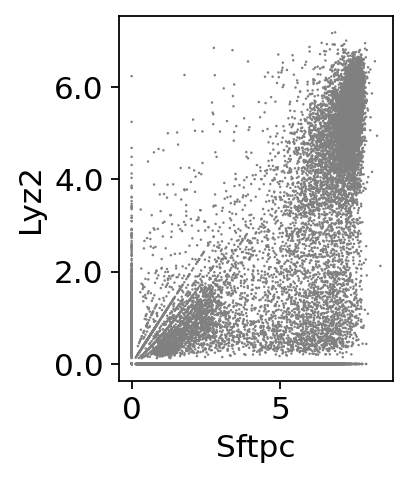

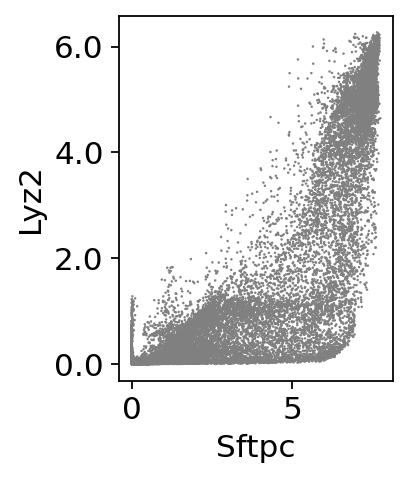

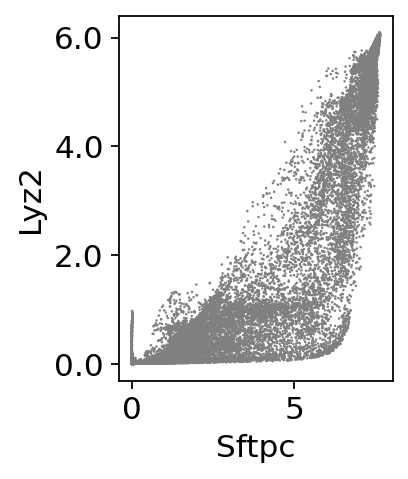

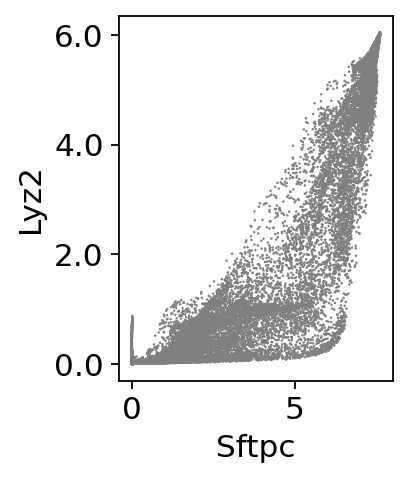

In [47]:
# Start timing the execution of the script
start = time.time()

# Create three copies of the AnnData object 'adata' to perform imputation with different 't' values
adata2 = adata.copy()
adata5 = adata.copy()
adata7 = adata.copy()

# Perform MAGIC imputation on each copy with different 't' values (PMID: 29961576)
# MAGIC is an algorithm for imputing missing data in single-cell gene expression datasets.
# It uses a Markov affinity-based graph to smooth out the data, helps revealing gene-gene relationships and recovering the structure of the data.
# 't' is the main parameter in MAGIC, controlling the extent of data diffusion (smoothing).
# 'knn' defines the number of nearest neighbors for the graph, and 'n_pca' is the number of principal components to use.

# Impute using t=2, t=5, and t=7
print('Performing MAGIC')
sce.pp.magic(adata2, name_list='all_genes', knn=5, t=2, n_pca=30)
sce.pp.magic(adata5, name_list='all_genes', knn=5, t=5, n_pca=30)
sce.pp.magic(adata7, name_list='all_genes', knn=5, t=7, n_pca=30)

# Prepare a list containing the original and imputed datasets
adata_list = [adata, adata2, adata5, adata7]
print('Plotting data')

# Plot correlation scatter plots for two genes ('Sftpc' and 'Lyz2') for each dataset with different imputation 't' values
for i in adata_list:
    with axes_style({'axes.grid': False}):  # Remove grid lines from the plot for better visual clarity
        ax = sc.pl.scatter(i, x='Sftpc', y='Lyz2', size=5, use_raw=False, show=False)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Format the y-axis labels

# Calculate and print the total runtime of the script in minutes
end = time.time()
print('Total run time (min):', (end - start)/60)

  Running MAGIC with `solver='exact'` on 21001-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


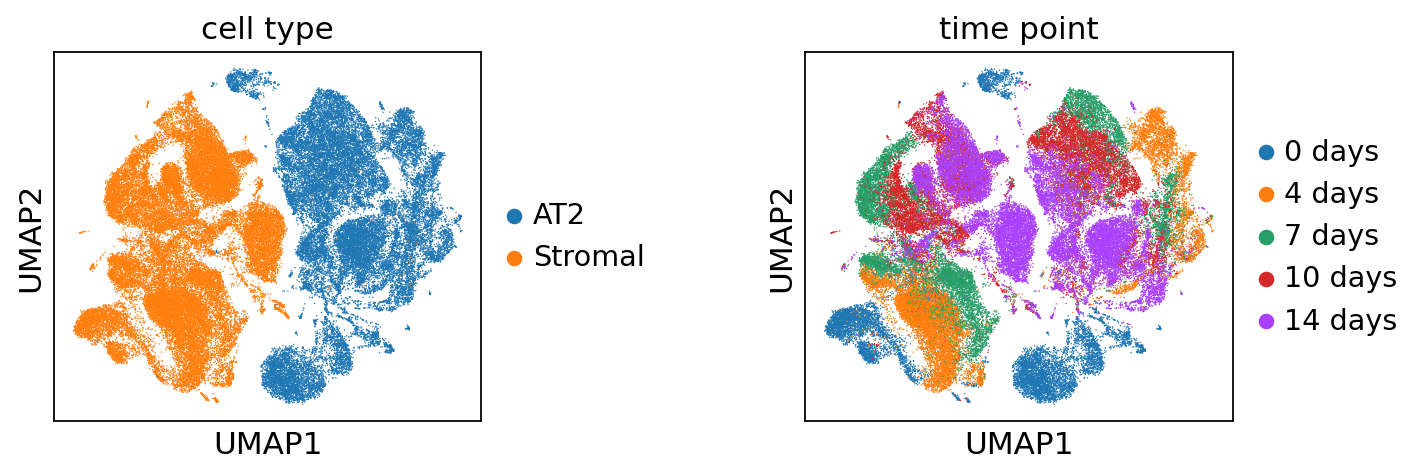

In [48]:
# Impute with MAGIC
sce.pp.magic(adata, name_list='all_genes', knn=5, t=5, n_pca=30)

# Calculate neighbors and UMAP on the imputed space
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=30)
sc.tl.umap(adata)

rcParams['figure.facecolor']='white'
sc.pl.umap(adata, color=['cell type','time point'], wspace=0.6, frameon=True)

#### Check for Club and Ciliated cell contamination, then remove from the data

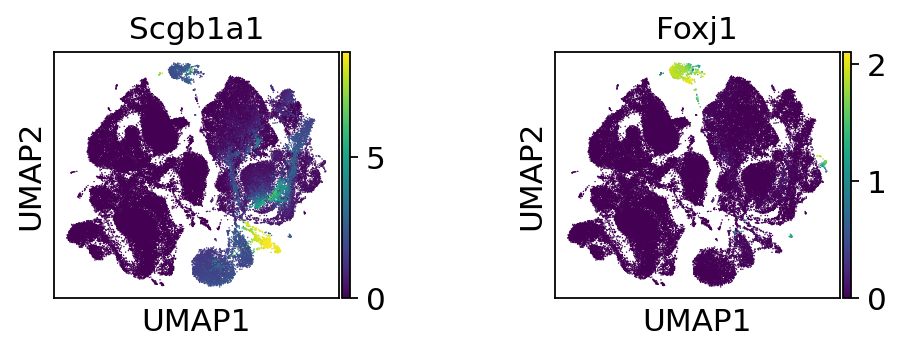

In [65]:
rcParams['figure.facecolor']='white'
sc.pl.umap(adata, color=['Scgb1a1','Foxj1'], wspace=0.6, frameon=True, use_raw=False, vmin=0)

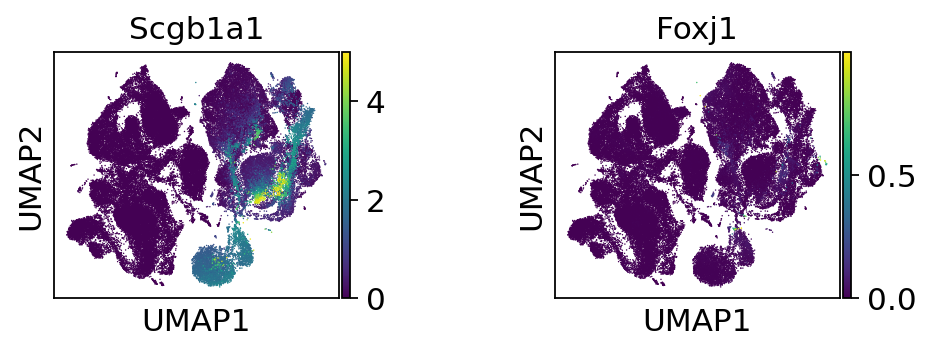

In [66]:
# Add 'Scgb1a1' and 'Foxj1' gene expression data as a new column in the observations (obs) of adata
adata.obs['Scgb1a1'] = adata[:, ['Scgb1a1']].to_df()
adata.obs['Foxj1'] = adata[:, ['Foxj1']].to_df()

# Filter out cells from adata where 'Scgb1a1' expression is 5 or more
adata = adata[adata.obs['Scgb1a1'] < 5, :]

# Filter out cells from adata where 'Foxj1' expression is 1 or more
adata = adata[adata.obs['Foxj1'] < 1, :]

# Set the figure background color to white for UMAP plots
rcParams['figure.facecolor'] = 'white'

# Plot UMAP with cells colored based on 'Scgb1a1' and 'Foxj1' expression
sc.pl.umap(adata, color=['Scgb1a1', 'Foxj1'], wspace=0.6, frameon=True, use_raw=False, vmin=0)

# Remove the columns 'Scgb1a1' and 'Foxj1' from adata.obs
adata.obs = adata.obs.drop(columns=['Scgb1a1', 'Foxj1'])

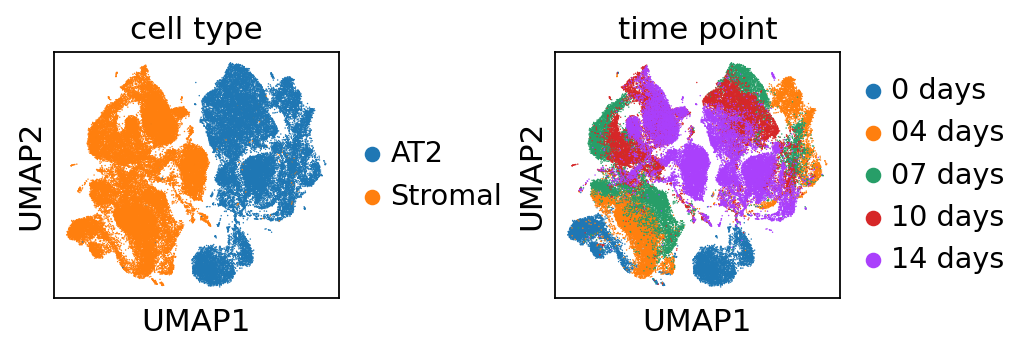

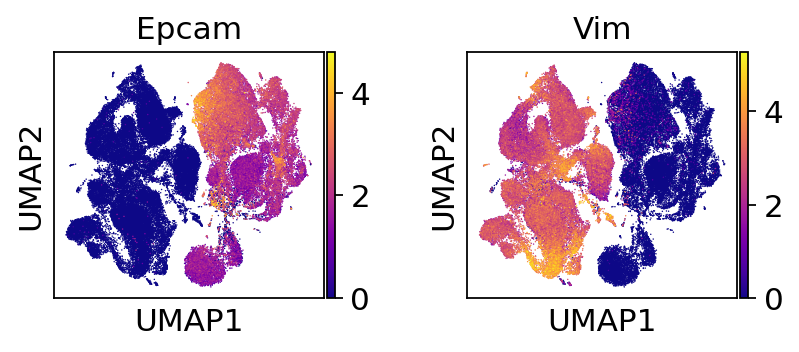

In [5]:
# replot
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=2,2
sc.pl.umap(adata, color=['cell type','time point'], wspace=0.6, frameon=True)
sc.pl.umap(adata, color=['Epcam','Vim'], cmap='plasma', vmin=0, frameon=True)

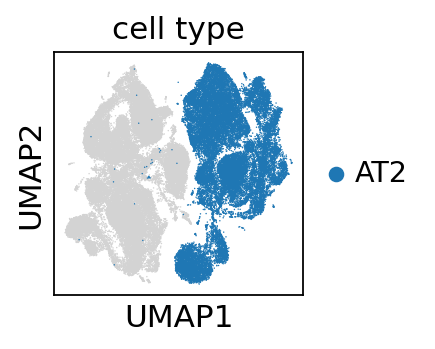

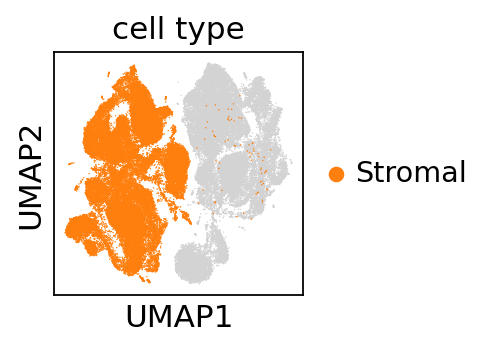

In [11]:
cellType = sorted(list(set(adata.obs['cell type'])))

for cell in cellType:
    rcParams["figure.facecolor"]='white'
    rcParams['figure.figsize']=2,2   
    sc.pl.umap(adata, color=['cell type'], groups=cell)

In [12]:
adata.obs['cell type'].value_counts()

Stromal    41319
AT2        29933
Name: cell type, dtype: int64

In [6]:
len(adata.obs.index)

71252

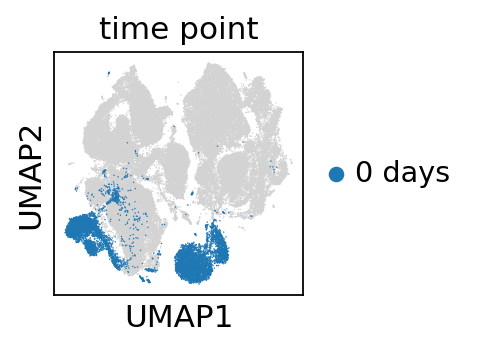

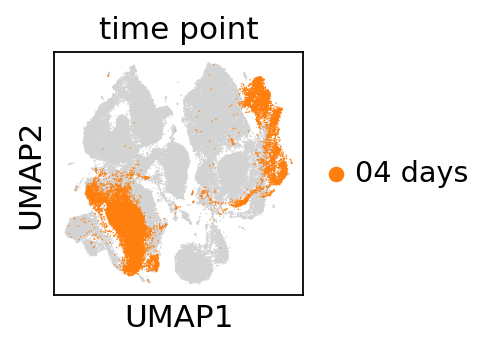

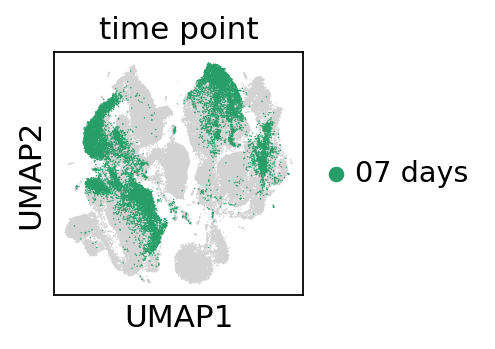

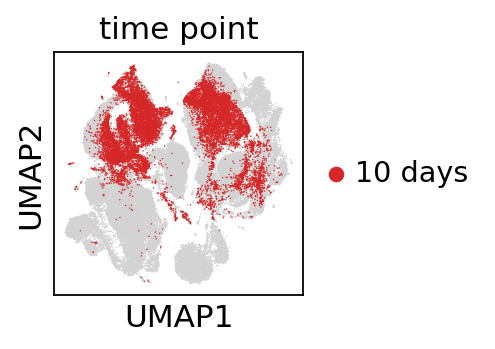

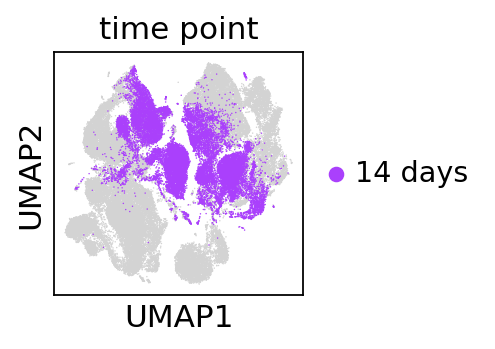

In [71]:
timePoint = sorted(list(set(adata.obs['time point'])))

for time in timePoint:
    rcParams["figure.facecolor"]='white'
    rcParams['figure.figsize']=2,2   
    sc.pl.umap(adata, color=['time point'], groups=time)

In [11]:
scores = adata.obs[['batch']]

# time point
annotation = pd.Series('Undetermined', index=scores.index)
annotation[(scores.batch == 'AD03')] = 'Fresh stromal'  
annotation[(scores.batch == 'AD01')|(scores.batch == 'AD04')|(scores.batch == 'AD05')|(scores.batch == 'AD08')|(scores.batch == 'AD09')|(scores.batch == 'AD12')|(scores.batch == 'AD13')|(scores.batch == 'AD16')|(scores.batch == 'AD17')] = 'Y'  
annotation[(scores.batch == 'AD02')|(scores.batch == 'AD06')|(scores.batch == 'AD07')|(scores.batch == 'AD10')|(scores.batch == 'AD11')|(scores.batch == 'AD14')|(scores.batch == 'AD15')|(scores.batch == 'AD18')|(scores.batch == 'AD19')] = 'KPY'  
adata.obs['yfpStatus'] = annotation

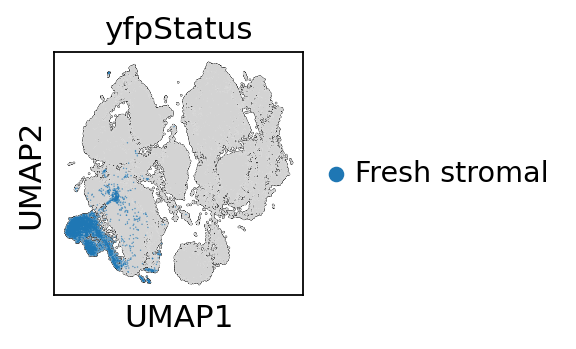

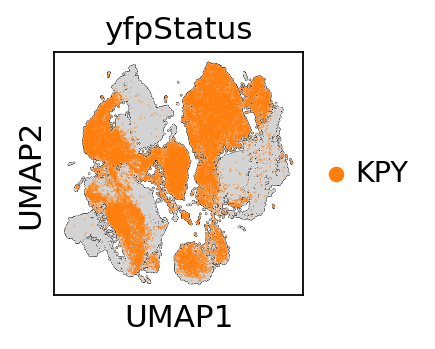

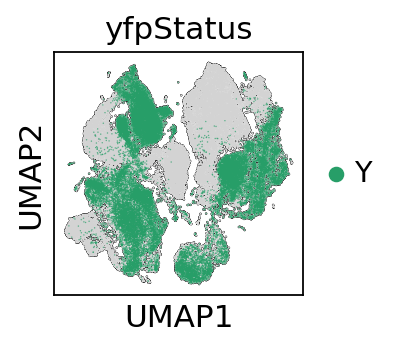

In [5]:
cellType = sorted(list(set(adata.obs['yfpStatus'])))

for cell in cellType:
    rcParams["figure.facecolor"]='white'
    rcParams['figure.figsize']=2,2   
    sc.pl.umap(adata, color=['yfpStatus'], groups=cell, add_outline=True)

#### Subset AT2 cells

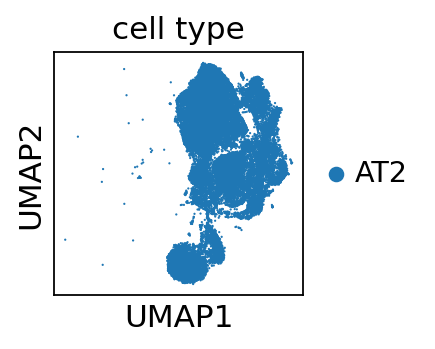

In [7]:
# subset data
at2Cells = adata[adata.obs['cell type'].isin(['AT2'])]

rcParams['figure.facecolor']='white'
sc.pl.umap(at2Cells, color='cell type')

In [13]:
scores = at2Cells.obs[['batch']]

annotation = pd.Series('Undetermined', index=scores.index)
annotation[(scores.batch == 'AD01')|(scores.batch == 'AD04')|(scores.batch == 'AD05')|(scores.batch == 'AD08')|(scores.batch == 'AD09')|(scores.batch == 'AD12')|(scores.batch == 'AD13')|(scores.batch == 'AD16')|(scores.batch == 'AD17')] = 'Y'  
annotation[(scores.batch == 'AD02')|(scores.batch == 'AD06')|(scores.batch == 'AD07')|(scores.batch == 'AD10')|(scores.batch == 'AD11')|(scores.batch == 'AD14')|(scores.batch == 'AD15')|(scores.batch == 'AD18')|(scores.batch == 'AD19')] = 'KPY'  
at2Cells.obs['yfpStatus'] = annotation

/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home/alm72/.conda/envs/KPYtimecourse/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/

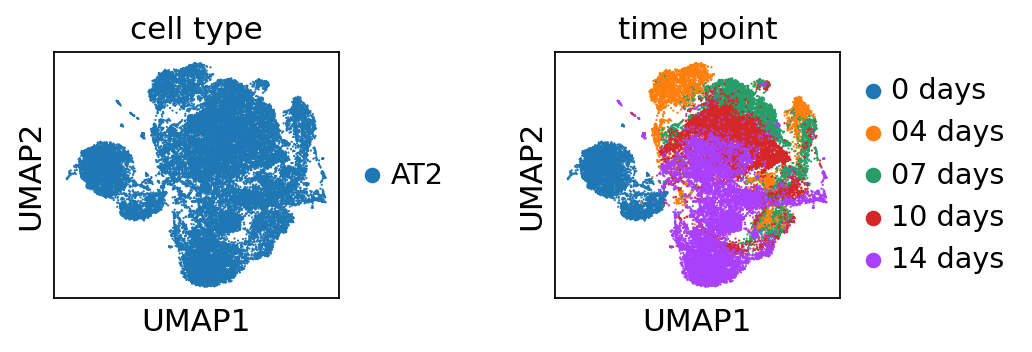

In [8]:
sc.pp.neighbors(at2Cells, n_neighbors=5, n_pcs=30)
sc.tl.umap(at2Cells)

rcParams['figure.facecolor']='white'
sc.pl.umap(at2Cells, color=['cell type','time point'], wspace=0.6, frameon=True)

In [3]:
len(at2Cells.obs.index)

29933

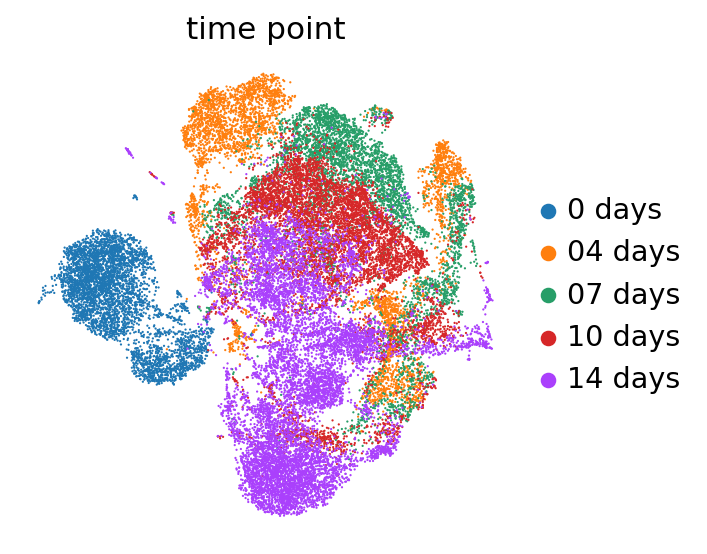

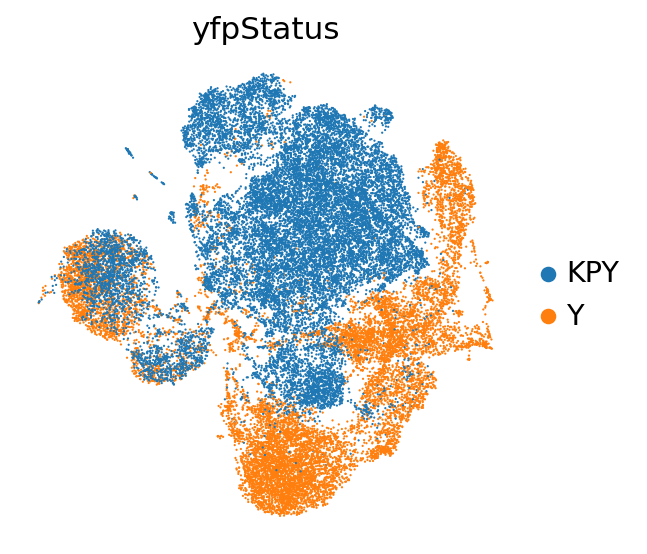

In [56]:
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=4,4
sc.pl.umap(at2Cells, color=['time point'], wspace=0.3, frameon=False)
sc.pl.umap(at2Cells, color=['yfpStatus'], wspace=0.3, frameon=False)

#### Make yfpStatus-time annotations

In [30]:
#### Batch-time correlation

scores = at2Cells.obs[['yfpStatus','time point']]

annotation = pd.Series('Undetermined', index=scores.index)
annotation[(scores['time point'] == '0 days') & (scores['yfpStatus'] == 'KPY')] = 'KPY 0 dy'  
annotation[(scores['time point'] == '04 days') & (scores['yfpStatus'] == 'KPY')] = 'KPY 4 dy'  
annotation[(scores['time point'] == '07 days') & (scores['yfpStatus'] == 'KPY')] = 'KPY 7 dy'  
annotation[(scores['time point'] == '10 days') & (scores['yfpStatus'] == 'KPY')] = 'KPY 10 dy'  
annotation[(scores['time point'] == '14 days') & (scores['yfpStatus'] == 'KPY')] = 'KPY 14 dy'  

annotation[(scores['time point'] == '0 days') & (scores['yfpStatus'] == 'Y')] = 'Y 0 dy'  
annotation[(scores['time point'] == '04 days') & (scores['yfpStatus'] == 'Y')] = 'Y 4 dy'  
annotation[(scores['time point'] == '07 days') & (scores['yfpStatus'] == 'Y')] = 'Y 7 dy'  
annotation[(scores['time point'] == '10 days') & (scores['yfpStatus'] == 'Y')] = 'Y 10 dy'  
annotation[(scores['time point'] == '14 days') & (scores['yfpStatus'] == 'Y')] = 'Y 14 dy'  

at2Cells.obs['yfp_time_annot'] = annotation

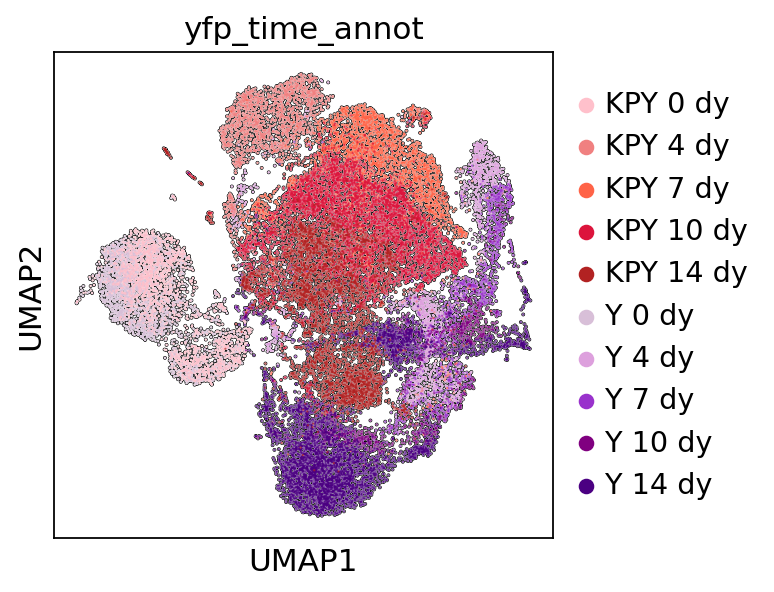

In [7]:
palette = ['pink', 'lightcoral', 'tomato', 'crimson', 'firebrick', 'thistle','plum','darkorchid','purple', 'indigo']

rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=4,4
sc.pl.umap(at2Cells, color=['yfp_time_annot'], wspace=0.3, frameon=True, palette=palette, add_outline=True)

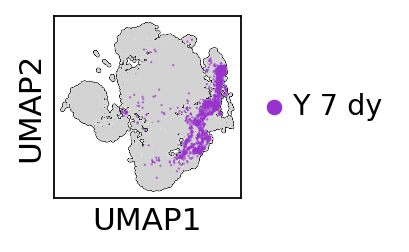

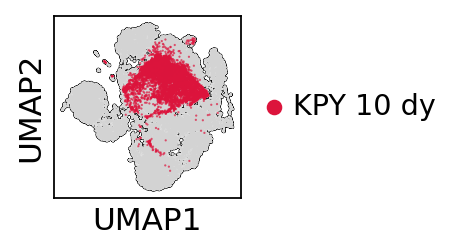

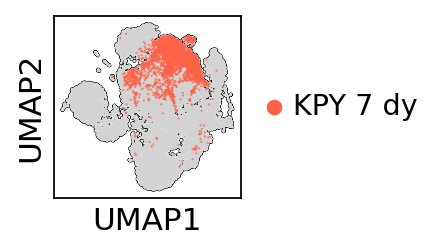

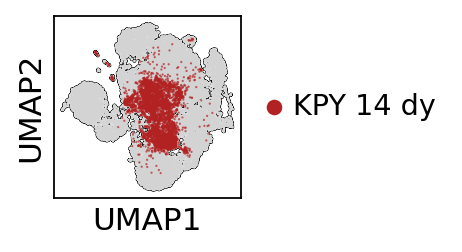

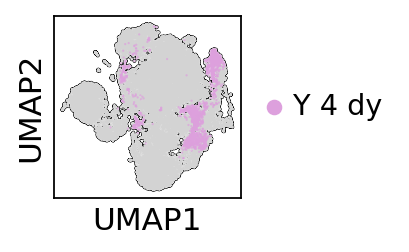

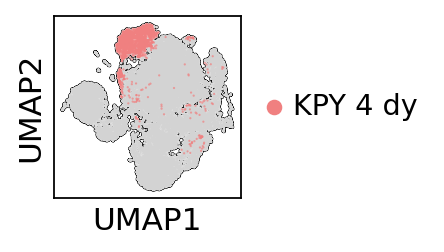

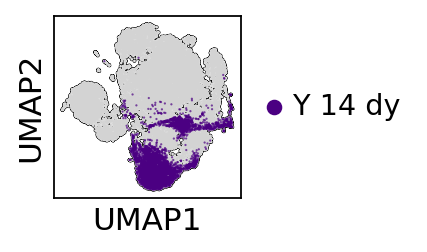

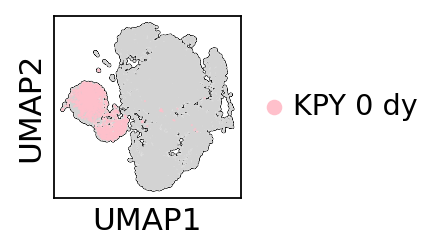

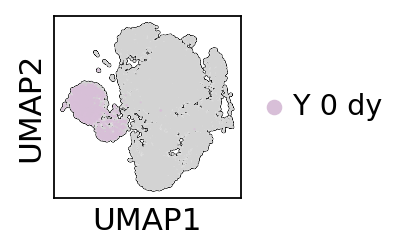

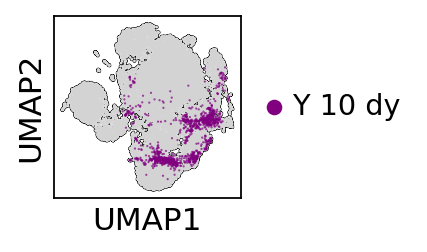

In [8]:
# Plot each annotation seperately

for i in list(set(at2Cells.obs['yfp_time_annot'])):
    rcParams['figure.facecolor']='white'
    rcParams['figure.figsize']=1.5,1.5
    sc.pl.umap(at2Cells, color=['yfp_time_annot'], groups = i, wspace=0.3, frameon=True, show=False, add_outline=True)
    plt.title('')

#### Make annotation for freshly sorted or organoid cells

In [11]:
scores = at2Cells.obs[['time point']]

annotation = pd.Series('Organoid', index=scores.index) # default annotation
annotation[(scores['time point'] == '0 days')] = 'Fresh'    

at2Cells.obs['fresh_org_annot'] = annotation

Text(0.5, 1.0, '')

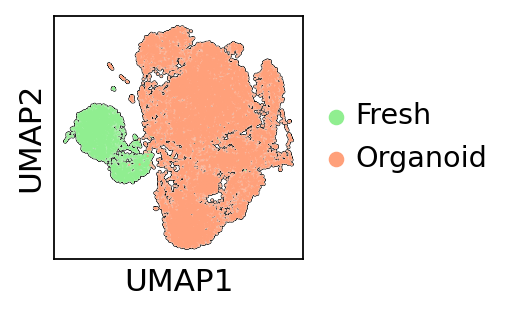

In [9]:
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=2,2
colors = ['lightgreen','lightsalmon']
sc.pl.umap(at2Cells, color=['fresh_org_annot'], wspace=0.3, frameon=True, palette = colors, show=False, add_outline=True)
plt.title('')

#### Detect clusters with Leiden

In [13]:
sc.tl.leiden(at2Cells, resolution=0.05, key_added='leiden0_05')
sc.tl.leiden(at2Cells, resolution=0.1, key_added='leiden0_1')
sc.tl.leiden(at2Cells, resolution=0.2, key_added='leiden0_2')
sc.tl.leiden(at2Cells, resolution=0.4, key_added='leiden0_4')

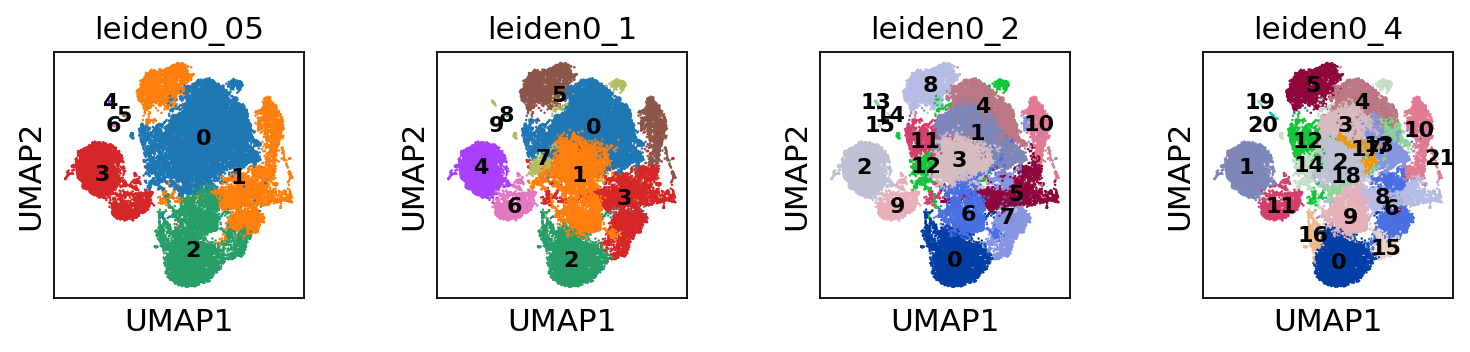

In [14]:
leiden_clusts=['leiden0_05','leiden0_1','leiden0_2','leiden0_4']

rcParams["figure.facecolor"]='white'
rcParams['figure.figsize'] = 2,2
sc.pl.umap(at2Cells, color=leiden_clusts, hspace=0.5, legend_fontsize=10,legend_loc='on data', size=5, frameon=True, show=False)

Text(0.5, 1.0, '')

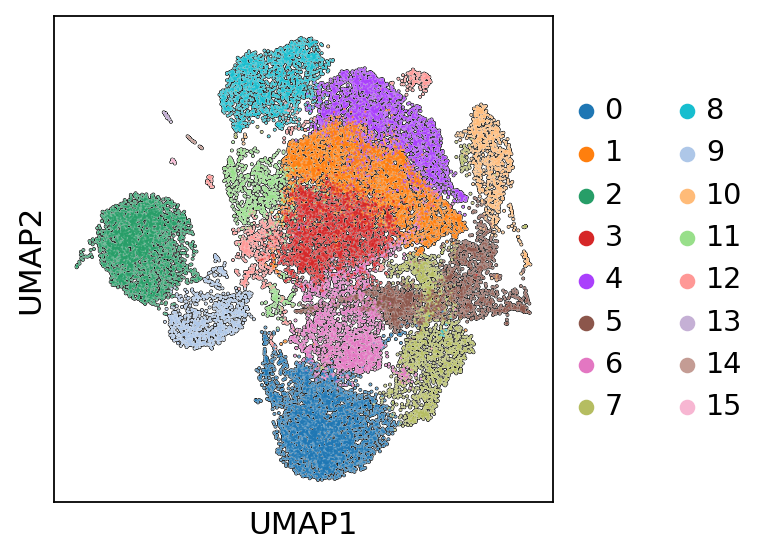

In [10]:
# leiden0_2
rcParams['figure.facecolor']='white'
rcParams['figure.figsize']=4,4
sc.pl.umap(at2Cells, color=['leiden0_2'], wspace=0.6, frameon=True, legend_loc='right margin', show=False, add_outline=True)
plt.title('')

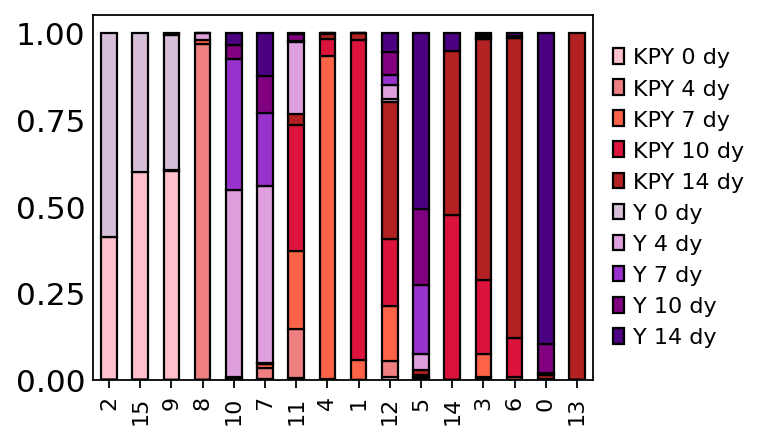

In [21]:
df=at2Cells.obs.copy()
df_plot = df.groupby(['leiden0_2', 'yfp_time_annot']).size().reset_index().pivot(columns='yfp_time_annot', index='leiden0_2', values=0)

# normalize rows
# Credit: https://stackoverflow.com/questions/26537878/pandas-sum-across-columns-and-divide-each-cell-from-that-value
df3 = df_plot.div(df_plot.sum(axis=1), axis=0)

order = ['KPY 0 dy','KPY 4 dy','KPY 7 dy','KPY 10 dy','KPY 14 dy',
        'Y 0 dy','Y 4 dy','Y 7 dy','Y 10 dy','Y 14 dy']
df3 = df3[order]

#df3 = df3.sort_values(by = ['0 days','14 days', '10 days'], ascending=[True, False, False])

# Manually order the rows according to yfpStatus contributions
df3 = df3.reindex(['2','15','9','8','10','7','11','4','1','12','5','14','3','6','0','13'])

# plot

color = at2Cells.uns['yfp_time_annot_colors']

rcParams['figure.figsize'] = 4,3
with axes_style({'axes.grid': False}):
    ax = df3.plot(kind='bar', stacked=True, edgecolor='black', color = color
                 )
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5), ncol=1, frameon=False, title='', 
    title_fontsize=10, fontsize=10)
    ax.set_xlabel("", rotation=0, labelpad=10, fontsize=10)
    ax.set_ylabel("", rotation=90, labelpad=10, fontsize=10)
    ax.set_xticklabels(df3.index, fontsize=10)
    #ax.set_yticklabels([0.0,0.5,1.0], fontsize=10)
    ax.tick_params(axis=u'y', which=u'both',length=0)
    #despine(right=True, left=True)

In [15]:
# Add order to at2Cells.uns for future use
at2Cells.uns.update({'leiden0_2_ordered':['2','15','9','8','10','7','11','4','1','12','5','14','3','6','0','13']})

#### Organoid DE analysis

In [6]:
ngenes = 3000
method = 'wilcoxon'
lst=['leiden0_2']
anndata = at2Cells

for resolution in lst:
    print(f'Performing DE analysis for resolution={resolution}...')
    sc.tl.rank_genes_groups(anndata, groupby=resolution, key_added=f'rank_genes_{resolution}',
    method = method, n_genes=ngenes)

    # save data to adata_subset.uns
    result = anndata.uns[f'rank_genes_{resolution}']
    groups = result['names'].dtype.names

de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

# Save DE results
result = at2Cells.uns['rank_genes_leiden0_2']
groups = result['names'].dtype.names
de_data = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

Performing DE analysis for resolution=leiden0_2...


#### Calculate epithelial signature scores data

In [3]:
# create dict
marker_dict={}

# add epi genes to dict
epi_df = pd.read_excel('path/epithelial_mesenchymal_marker_genes.xlsx', sheet_name='epithelial', header=0)
epi_list = ['Pulmonary alveolar type II cells','Pulmonary alveolar type I cells','Clara cells','Ciliated cells']

# Use genes common to human and mouse
for i in epi_list:
        subset = epi_df.loc[(epi_df['cell type'] == i) & (epi_df['species'] == 'Mm Hs')]
        genes = subset['official gene symbol'].tolist()
        genes = [x.lower() for x in genes] # lower names
        genes = [x.capitalize() for x in genes] # capitalize names
        marker_dict[i] = genes # create key, value pairs

# Change epithelial cell names
marker_dict['Club sig'] = marker_dict.pop('Clara cells')
marker_dict['AT2 sig'] = marker_dict.pop('Pulmonary alveolar type II cells')
marker_dict['AT1 sig'] = marker_dict.pop('Pulmonary alveolar type I cells')
marker_dict['Ciliated sig'] = marker_dict.pop('Ciliated cells')

for k,v in marker_dict.items():
    print(f'{k}:', len(v))

# Create a cell_barcodes column to use as 'partition_key' input
import time
start = time.time()

at2Cells.obs['cell_barcodes'] = at2Cells.obs.index  # cell barcodes
print('Number of cells to calculate scores for:', len(at2Cells.obs.index))

# Defined a signature score function

print('Defining function')

def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key=None):
  
    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        
    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
           
    # I created a column based on index. This allows z-score calculation on single cells rather than clusters
    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        start = time.time()
        print(f'Calculating score for {group}')
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1
        end = time.time()
        print(f'Time to calculate signature score for {group} (min):', (end - start)/60)
    
    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise
    
    print('Creating dataframe with signature results')
    
    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())
    
    return marker_res_df

# Calculate the z-score
df = evaluate_partition(at2Cells, marker_dict, gene_symbol_key=None, partition_key = 'cell_barcodes')

# Transpose the dataframe
df_transposed = df.transpose()

# save signatures
print('Adding signature to adata.obs')
for i in df_transposed.columns:
    at2Cells.obs[f'{i}'] = df_transposed[f'{i}']

end = time.time()
print(f'Done. Total time to calculate signature scores of {len(df_transposed.columns)} clusters (min):', (end - start)/60)

Club sig: 22
AT2 sig: 38
AT1 sig: 34
Ciliated sig: 15
Number of cells to calculate scores for: 29933
Defining function
Calculating score for Club sig
Time to calculate signature score for Club sig (min): 3.2869011958440146
Calculating score for AT2 sig
Time to calculate signature score for AT2 sig (min): 5.499659669399262
Calculating score for AT1 sig
Time to calculate signature score for AT1 sig (min): 4.987501490116119
Calculating score for Ciliated sig
Time to calculate signature score for Ciliated sig (min): 2.3623722473780315
Creating dataframe with signature results
Adding signature to adata.obs
Done. Total time to calculate signature scores of 4 clusters (min): 16.26901319424311
